In [5]:
import os
import time
import sys
import scipy
import glob
import importlib
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [6]:
util.set_sns_style(style='dark', min_fontsize=12)
%matplotlib notebook

In [7]:
# rootdir = '/mnt/minerva/plume-tracking/behavior'
rootdir = '/Volumes/Julie/plume-tracking/behavior'
experiment = 'strip_grid'

srcdir = os.path.join(rootdir, experiment)
logdir = os.path.join(srcdir, 'logfiles')

figdir = os.path.join(srcdir, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print("Saving figures to: {}".format(figdir))

fig_id = srcdir

Saving figures to: /Volumes/Julie/plume-tracking/behavior/strip_grid/figures


In [23]:

def load_df(fpath):
    config  = butil.load_experiment_config(fpath)
    #if config is not 
    strip_width = config['experiment']['strip_width'] if config is not None else 20 #50
    if fn in ['20230106-121556_strip_grid_fly1_000.log', '20230105-182650_strip_grid_fly1_004.log']:
        strip_sep_default = 200
    else:
        strip_sep_default = 400
    strip_sep = config['experiment']['strip_spacing'] if config is not None else strip_sep_default # 400

    df0_full = butil.load_dataframe(fpath, remove_invalid=False)
    df0_full = butil.process_df(df0_full)

    odor_ix = df0_full[df0_full['instrip']].iloc[0].name

    odor_bounds = butil.find_strip_borders(df0_full, entry_ix=odor_ix,
                                           strip_width=strip_width, strip_sep=strip_sep)
    
    oparams = {
        'odor_ix': odor_ix,
        'odor_bounds': odor_bounds,
        'strip_width': strip_width, 
        'strip_sep': strip_sep
    }
    return df0_full, oparams#odor_ix, odor_bounds, strip_width, strip_sep



In [29]:
def find_et_bouts(df0, odor_bounds, strip_width=50, strip_sep=500):
    et_bouts = {}
    et_boutstats = {}
    for oi, ob in enumerate(odor_bounds):
        if len(odor_bounds)>1:
            curr_ob_min = min(ob)
            next_ob_min = max(ob)+strip_sep/2. #min(odor_bounds[oi+1]) if oi<(len(odor_bounds)-1) else max(ob)
            # get df up until *next* odor strip
            within_bounds = df0[ (df0['instrip']) \
                                & (df0['ft_posx']>=curr_ob_min) \
                                & (df0['ft_posx'] < next_ob_min)].copy()        
            #df_ = df0[ (df0['ft_poxs']>=curr_ob_min) & (df0['ft_posx'] < next_ob_min)].copy()
            start_bout, end_bout = within_bounds['boutnum'].min(), within_bounds['boutnum'].max()
            df_ = df0[(df0['boutnum']>=start_bout) & (df0['boutnum']<=end_bout)].copy()
            print(oi, start_bout, end_bout, next_ob_min, df_.shape)
        else:
            df_ = df0.copy()
            start_bout = df0[df0['instrip']].iloc[0]['boutnum'].min() + 1 # start from 1st outbout
            end_bout = df0[df0['instrip']]['boutnum'].max()
        if df_.shape[0]==0:
            continue
        print( "{}: starts instrip {}".format(oi, df_['instrip'].iloc[0]))
        # calculate duration and N in/outbouts of current ET bout
        #start_bout = df_[df_['instrip']].iloc[0]['boutnum']+1 # measure from first outbout
        #end_bout = df_[df_['instrip']]['boutnum'].max() # until last inbout

        measure_bout = df_[(df_['boutnum']>=start_bout) & (df_['boutnum']<=end_bout)].copy()
        upwind_dist = measure_bout['upwind_dist'].sum()
        n_bouts = len(measure_bout['boutnum'].unique())
        entry_ix = df_[df_['ft_posx']>ob[0]].iloc[0].name
        et_boutstats.update({
            oi: {
                'upwind_dist': upwind_dist,
                'n_bouts': n_bouts,
                'key': 'c{}'.format(entry_ix)
            }
        })
        # check if ET
        is_et = butil.is_edgetracking(df_, strip_width=strip_width, \
                            min_outside_bouts=3, min_upwind_dist=200)
        if is_et:
            print("Is ET:", oi, is_et)
            et_bouts.update({'c{}'.format(entry_ix): ob})
    return et_bouts, et_boutstats

In [36]:
def get_best_et_boutkey(et_boutstats):
    sorted_ets = sorted(list(et_boutstats.values()), \
                   key=lambda k: (float(k['upwind_dist']), k['n_bouts']), reverse=True)
    et_id = [k for k, v in et_boutstats.items() \
             if all([v[i]==sorted_ets[0][i] for i in list(v.keys())])][0]
    
    et_boutkey = et_boutstats[et_id]['key']
    return et_boutkey

def select_best_et_bout(et_boutkey, et_bouts, df0_full, strip_sep=500):
    # select from 
    next_ob = et_bouts[et_boutkey][0]
    # print(next_ob)
    # start from previou outbout, if exists
    odor_ix = df0_full[df0_full['ft_posx']>=next_ob].iloc[0].name
    et_startbout = df0_full.loc[odor_ix]['boutnum'] #-1
    # make sure not including another strip, if exists
    past_current_strip_x = et_bouts[et_boutkey][1] + strip_sep/2
    et_lastbout = df0_full[ (df0_full['instrip']) \
                           & (df0_full['ft_posx']>=past_current_strip_x)]['boutnum'].min()
    if et_lastbout is not np.nan:
        et_lastbout -= 1
    else:
        et_lastbout = df0_full['boutnum'].max()
    print(et_startbout, et_lastbout)
    df0 = df0_full[(df0_full['boutnum']>=et_startbout)
                  & (df0_full['boutnum']<=et_lastbout)].copy() # include prev bout for "entry into" odor 

    et_bouts = dict((k, v) for k, v in et_bouts.items() if k==et_boutkey)
    #et_bouts

    return df0, odor_ix, et_bouts


In [72]:
def check_and_flip_traj(df0_full, et_boutkey, et_boutstats):
    all_et_starts = [int(v['key'][1:]) for k, v in et_boutstats.items()]

    tmp_start_ix = int(et_boutkey[1:])-1
    ix = all_et_starts.index(tmp_start_ix+1)
    if len(all_et_starts)>1:
        tmp_end_ix = all_et_starts[ix+1] if tmp_start_ix < max(all_et_starts)-1\
                            else df0_full.iloc[-1].name
    else:
        tmp_end_ix = df0_full.iloc[-1].name
    print(tmp_start_ix, tmp_end_ix)
    dfp, obounds_fp = butil.check_entryside_and_flip(df0_full.loc[tmp_start_ix:tmp_end_ix].copy(), 
                                            odor_dict=et_bouts,
                                         strip_width=strip_width)
    return dfp, obounds_fp

In [47]:
def calculate_tortuosity_metrics(df, xdist_cutoff=1.9, xvar='ft_posx', yvar='ft_posy'):

    last_outbout = df[~df['instrip']]['boutnum'].max()
    max_boutnum = df['boutnum'].max()
    skip_last_bout = last_outbout==max_boutnum

    # do it
    d_list = []
    for bnum, bdf in df[~df['instrip']].groupby('boutnum'):
        if bnum == last_outbout and skip_last_bout:
            continue
        max_ix = np.argmax(bdf[xvar])
        if max_ix==0: # this bout is flipped out to negative side, do flipLR
            bdf['ft_posx'], bdf['ft_posy'] = util.fliplr_coordinates(bdf['ft_posx'].values, \
                                             bdf['ft_posy'].values)
            max_ix = np.argmax(bdf[xvar])
            print(max_ix)
        min_ix = np.argmin(bdf[xvar])
        maxdist_x = bdf.iloc[max_ix][xvar] - bdf.iloc[min_ix][xvar]
        if maxdist_x < xdist_cutoff:
            continue

        outbound_traj = bdf.iloc[0:max_ix][[xvar, yvar]].values
        inbound_traj = bdf.iloc[max_ix:][[xvar, yvar]].values
        # path length
        pathlength_out = util.path_length(outbound_traj)
        pathlength_in = util.path_length(inbound_traj)
        # tortuosity 
        tort_outbound = util.calculate_tortuosity(outbound_traj)
        tort_inbound = util.calculate_tortuosity(inbound_traj)
        # efficiency of path
        xpathlength_out = util.path_length(outbound_traj, axis='x')
        xpathlength_in = util.path_length(inbound_traj, axis='x')

        # combine
        d_ = pd.DataFrame({
            'boutnum': [bnum]*2,
            'boutdir': ['outbound', 'inbound'],
            'pathlength': [pathlength_out, pathlength_in],
            'tortuosity': [tort_outbound, tort_inbound],
            'xpath_length': [xpathlength_out, xpathlength_in],
            'efficiency': [xpathlength_out/maxdist_x, xpathlength_in/maxdist_x],
            'maxdist_x': [maxdist_x]*2,
            'max_xpos': [bdf.iloc[max_ix]['ft_posx']]*2,
            'max_ix': [max_ix]*2,
        })

        d_list.append(d_)

    tortdf = pd.concat(d_list,axis=0).reset_index(drop=True)
    
    return tortdf


In [55]:
def plot_tortuosity_metrics(tortdf, cdf=False,
                            boutdir_palette={'outbound': 'cyan', 'inbound': 'violet'}):
    fig, axn = pl.subplots(1, 3, figsize=(8,4))
    ax=axn[0]
    ax=sns.histplot(data=tortdf, x='pathlength', hue='boutdir', ax=ax, palette=boutdir_palette,
                 cumulative=cdf, fill=False, element='poly', stat='probability',
                 common_norm=False)
    ax=axn[1]
    ax=sns.histplot(data=tortdf, x='tortuosity', hue='boutdir', ax=ax, palette=boutdir_palette,
                 cumulative=cdf, fill=False, element='poly', stat='probability',
                 common_norm=False)
    ax=axn[2]
    ax=sns.histplot(data=tortdf, x='efficiency', hue='boutdir', ax=ax, palette=boutdir_palette,
                 cumulative=cdf, fill=False, element='poly', stat='probability',
                 common_norm=False)
    for ai, ax in enumerate(axn):
        ax.set_box_aspect(1)
        if ai==2:
            h, l = ax.get_legend_handles_labels()
            #l = ax.legend_data.keys()
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
        else:
            ax.legend_.remove()
    pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5)
    return fig

In [53]:
# fn = '20230106-121556_strip_grid_fly1_000.log'

fns = [
    '20230126-175229_strip_grid_fly1_001.log',
    '20230112-155809_strip_grid_fly4_000.log',
    '20230112-110700_strip_grid_fly1_002.log',
    '20230111-140918_strip_grid_fly1_000.log',
    '20230105-182650_strip_grid_fly1_004.log',
    '20230106-121556_strip_grid_fly1_000.log'
]


0: starts instrip True
Is ET: 0 True
1 69
5460 85336
Not flipping borders
0


<IPython.core.display.Javascript object>


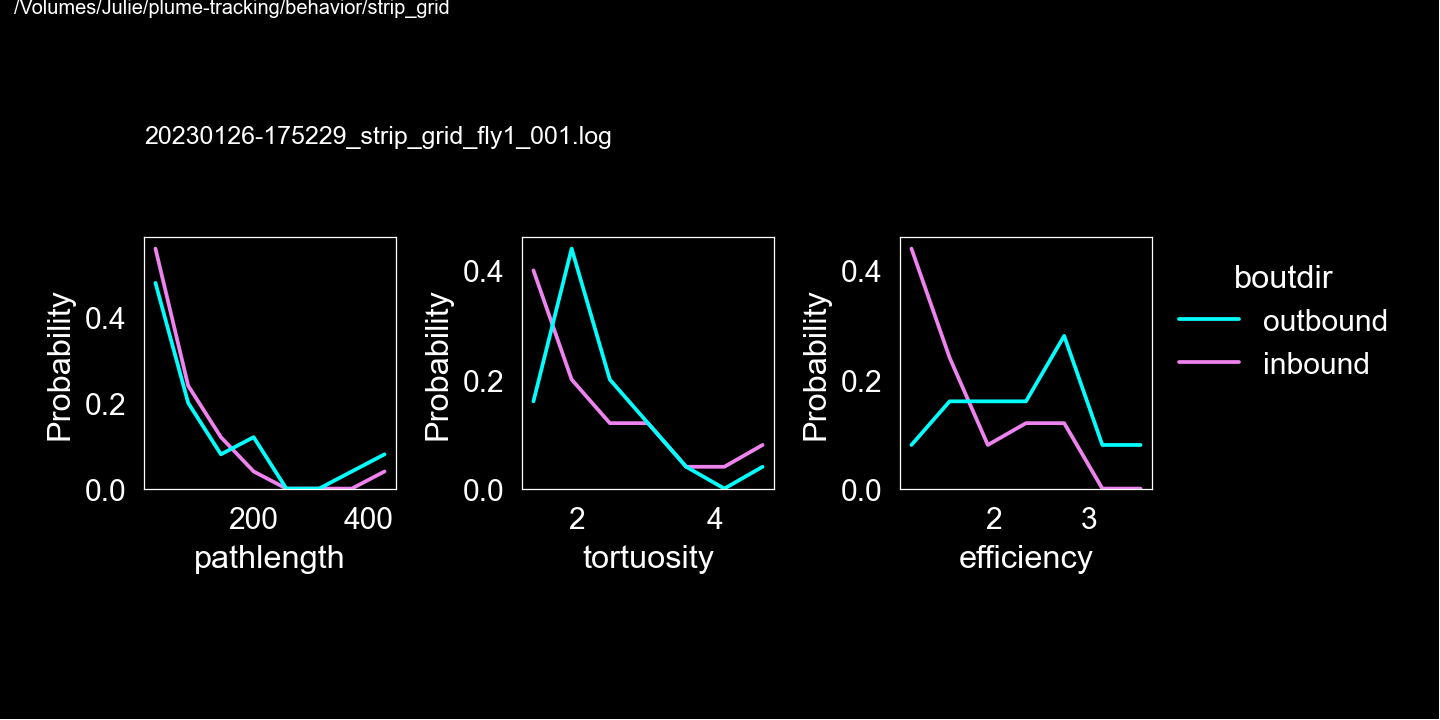

0 2 4 323.83493230039846 (2657, 40)
0: starts instrip True
1 6 32 773.5841397149661 (33232, 40)
1: starts instrip True
Is ET: 1 True
5 33
27460 61004
0


<IPython.core.display.Javascript object>


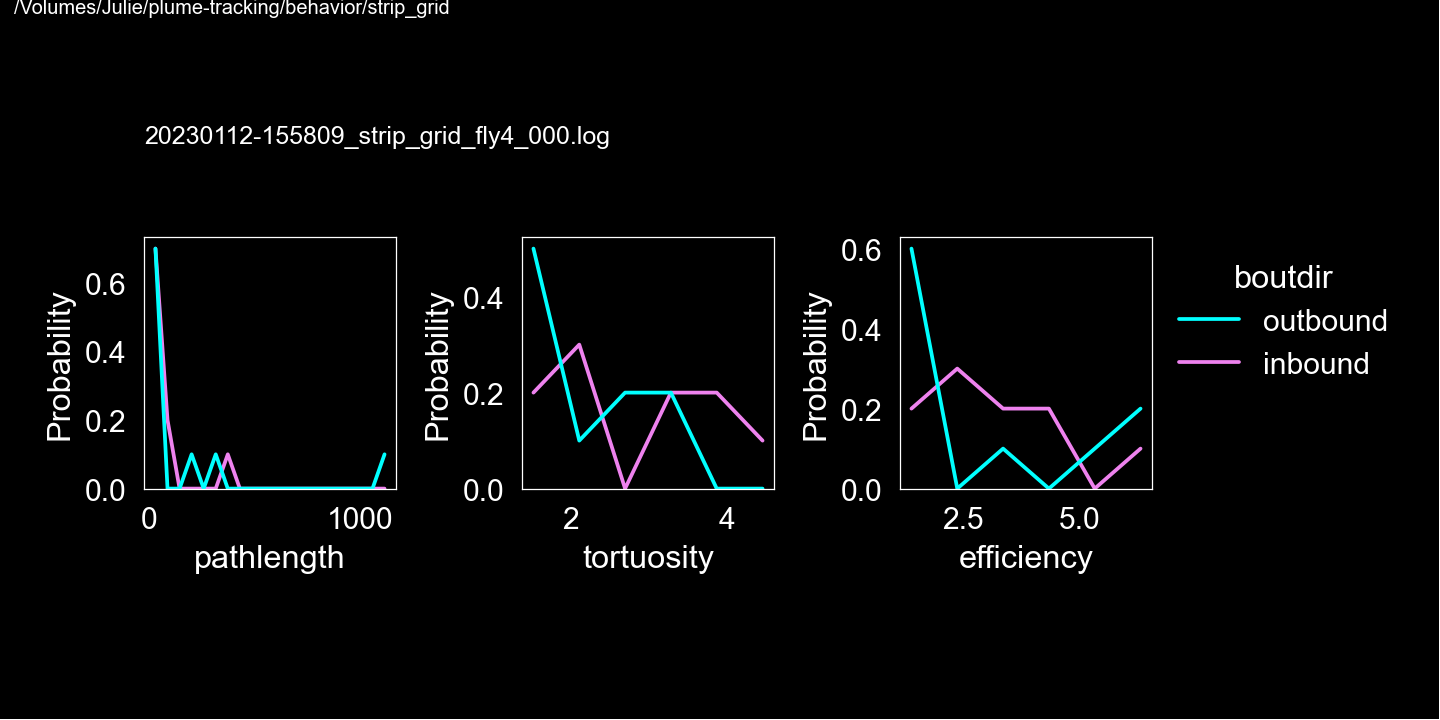

0 2 62 90.27456764266549 (29008, 40)
0: starts instrip True
Is ET: 0 True
1 64 104 540.4039329849325 (20345, 40)
1: starts instrip True
Is ET: 1 True
1 63
5488 47674
0
13176


/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


<IPython.core.display.Javascript object>


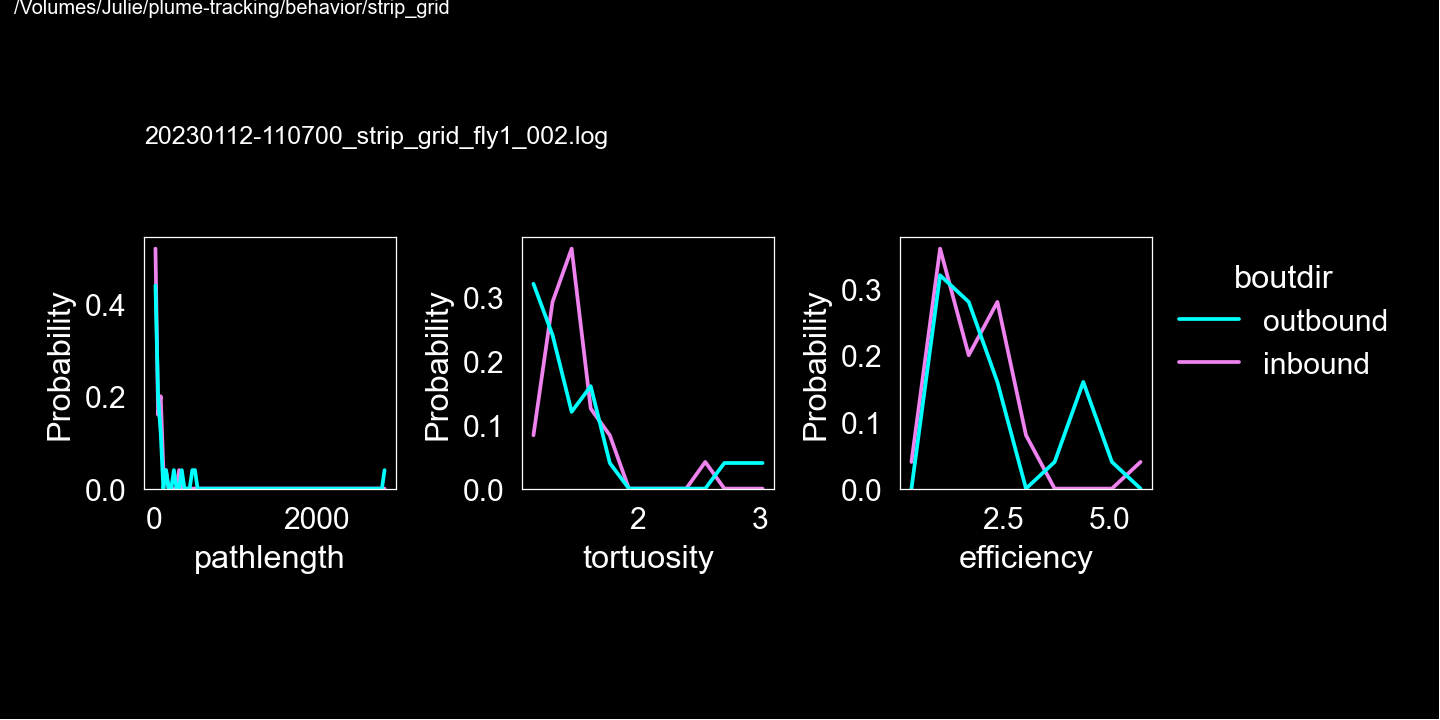

0 2 4 291.41078597079127 (721, 40)
0: starts instrip True
1 6 38 741.4144452364021 (37272, 40)
1: starts instrip True
Is ET: 1 True
6 39
21960 65537


<IPython.core.display.Javascript object>


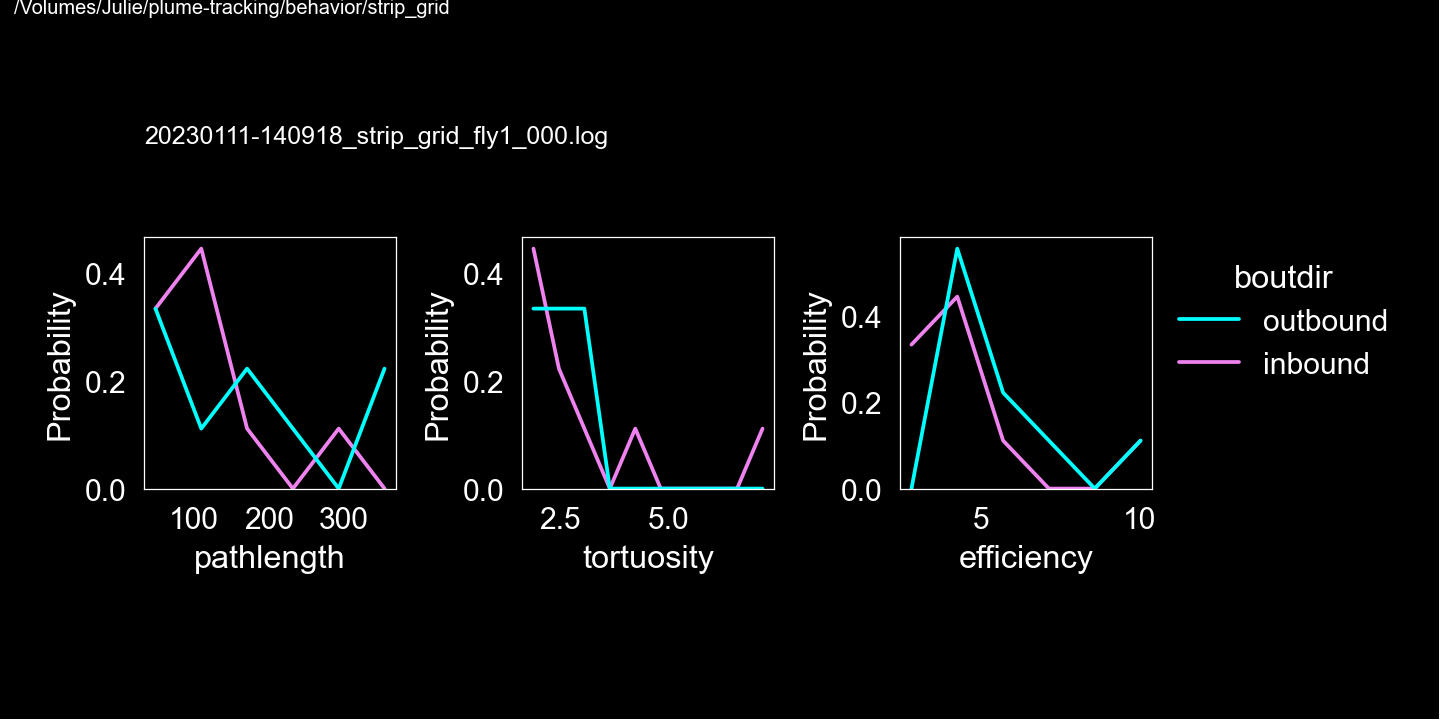

0 2 16 125.42536939340604 (18664, 40)
0: starts instrip True
Is ET: 0 True
1 18 60 345.44476537004084 (40630, 40)
1: starts instrip True
Is ET: 1 True
18 61
60986 108402
35


/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


<IPython.core.display.Javascript object>


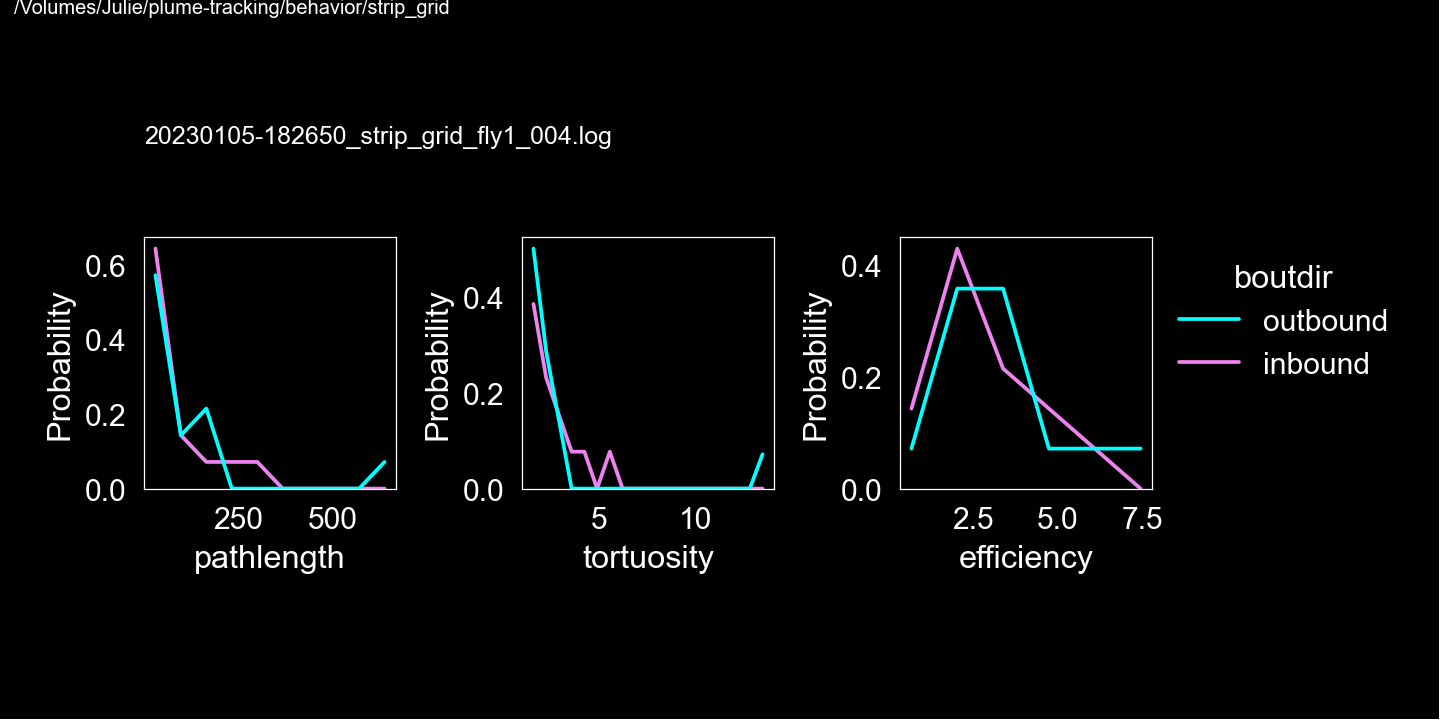

0 2 2 -16.579111935052993 (1225, 40)
0: starts instrip True
1 4 56 203.35916597671547 (47932, 40)
1: starts instrip True
Is ET: 1 True
2 58 58 423.42446466398496 (680, 40)
2: starts instrip True
3 57
16851 76183
Not flipping borders
0


/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


<IPython.core.display.Javascript object>


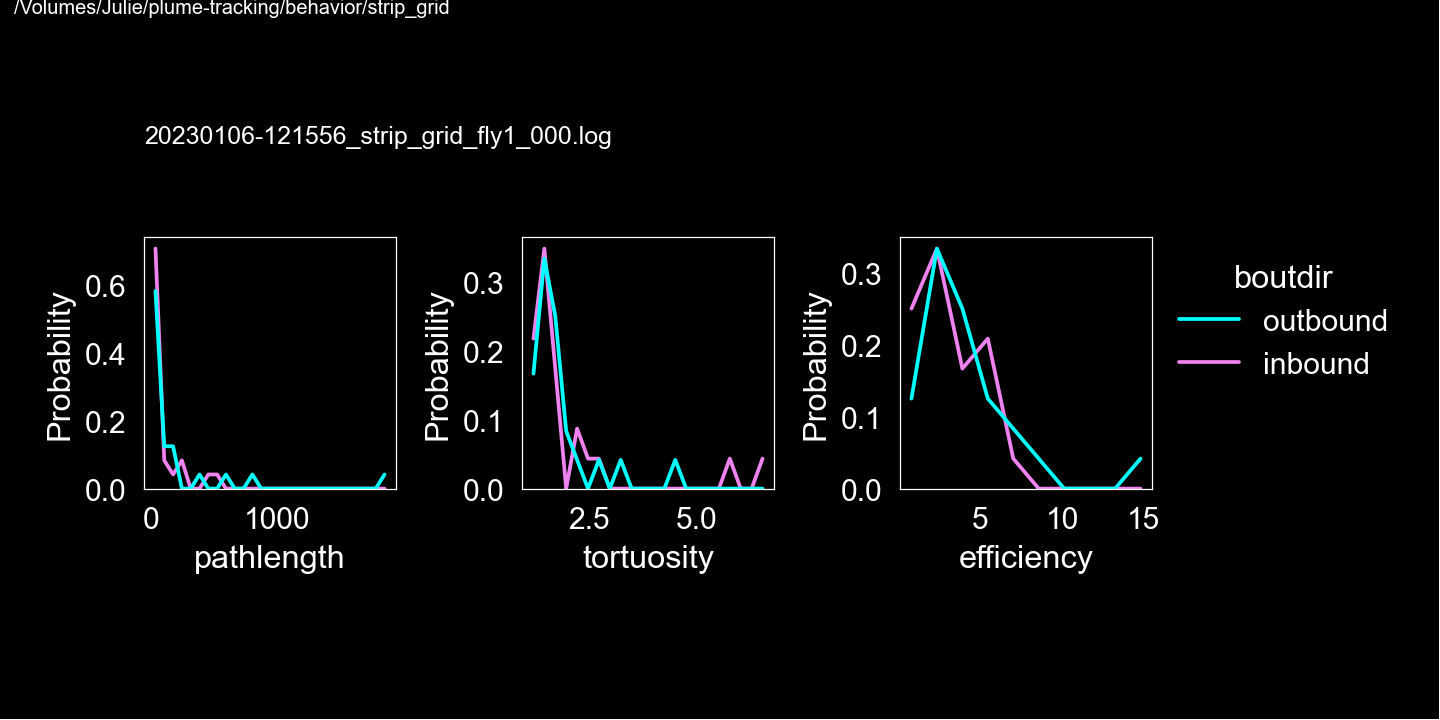

In [77]:
t_list= []
for fn in fns:
    fpath = os.path.join(logdir, fn)
    # load df and get odor strip info
    df0_full, oparams = load_df(fpath)
    odor_ix = oparams['odor_ix']
    odor_bounds = oparams['odor_bounds']
    strip_width, strip_sep = oparams['strip_width'], oparams['strip_sep']
    # start from odor onset
    df0 = df0_full.loc[odor_ix:].copy()
    # find all ET bouts (in case there is more than 1)
    et_bouts, et_boutstats = find_et_bouts(df0, odor_bounds, 
                                    strip_width=strip_width, strip_sep=strip_sep)
    et_boutkey = get_best_et_boutkey(et_boutstats)
    # select best ET
    df0, odor_ix, et_bouts = select_best_et_bout(et_boutkey, et_bouts, df0_full, strip_sep=strip_sep)
    # flip trajectory so all riding along strip's right side
    dfp, obounds_fp = check_and_flip_traj(df0_full, et_boutkey, et_boutstats)
    # get final DF
    df = dfp.loc[odor_ix:].copy()
    obounds = list(obounds_fp.values())
    # calculate tortuosity metrics
    tortdf = calculate_tortuosity_metrics(df, xdist_cutoff=1.9)
    tortdf['filename'] = fn
    
    fig = plot_tortuosity_metrics(tortdf, cdf=False, boutdir_palette=boutdir_palette)
    util.label_figure(fig, "{}".format(fig_id))
    fig.text(0.1, 0.8, fn)
    pl.subplots_adjust(right=0.8)
    
    t_list.append(tortdf)

In [78]:
tdf = pd.concat(t_list, axis=0).reset_index(drop=True)


In [79]:
tdf.columns

Index(['boutnum', 'boutdir', 'pathlength', 'tortuosity', 'xpath_length',
       'efficiency', 'maxdist_x', 'max_xpos', 'max_ix', 'filename'],
      dtype='object')

In [82]:
meandf = tdf.groupby(['filename', 'boutdir']).mean().reset_index()
meandf.head()

,filename,boutdir,boutnum,pathlength,tortuosity,xpath_length,efficiency,maxdist_x,max_xpos,max_ix
0,20230105-182650_strip_grid_fly1_004.log,inbound,37.285714,85.264285,2.576079,52.116264,2.766830,17.734417,-209.524428,1235.357143
1,20230105-182650_strip_grid_fly1_004.log,outbound,37.285714,113.195486,2.862909,68.688990,3.393484,17.734417,-209.524428,1235.357143
2,20230106-121556_strip_grid_fly1_000.log,inbound,30.333333,88.792020,2.021976,47.209001,2.958228,20.129173,121.398175,1274.125000
3,20230106-121556_strip_grid_fly1_000.log,outbound,30.333333,204.357016,1.825196,102.855985,4.179428,20.129173,121.398175,1274.125000
4,20230111-140918_strip_grid_fly1_000.log,inbound,22.777778,111.417576,3.011359,61.648971,4.300393,15.884275,-475.585274,1880.222222


<IPython.core.display.Javascript object>


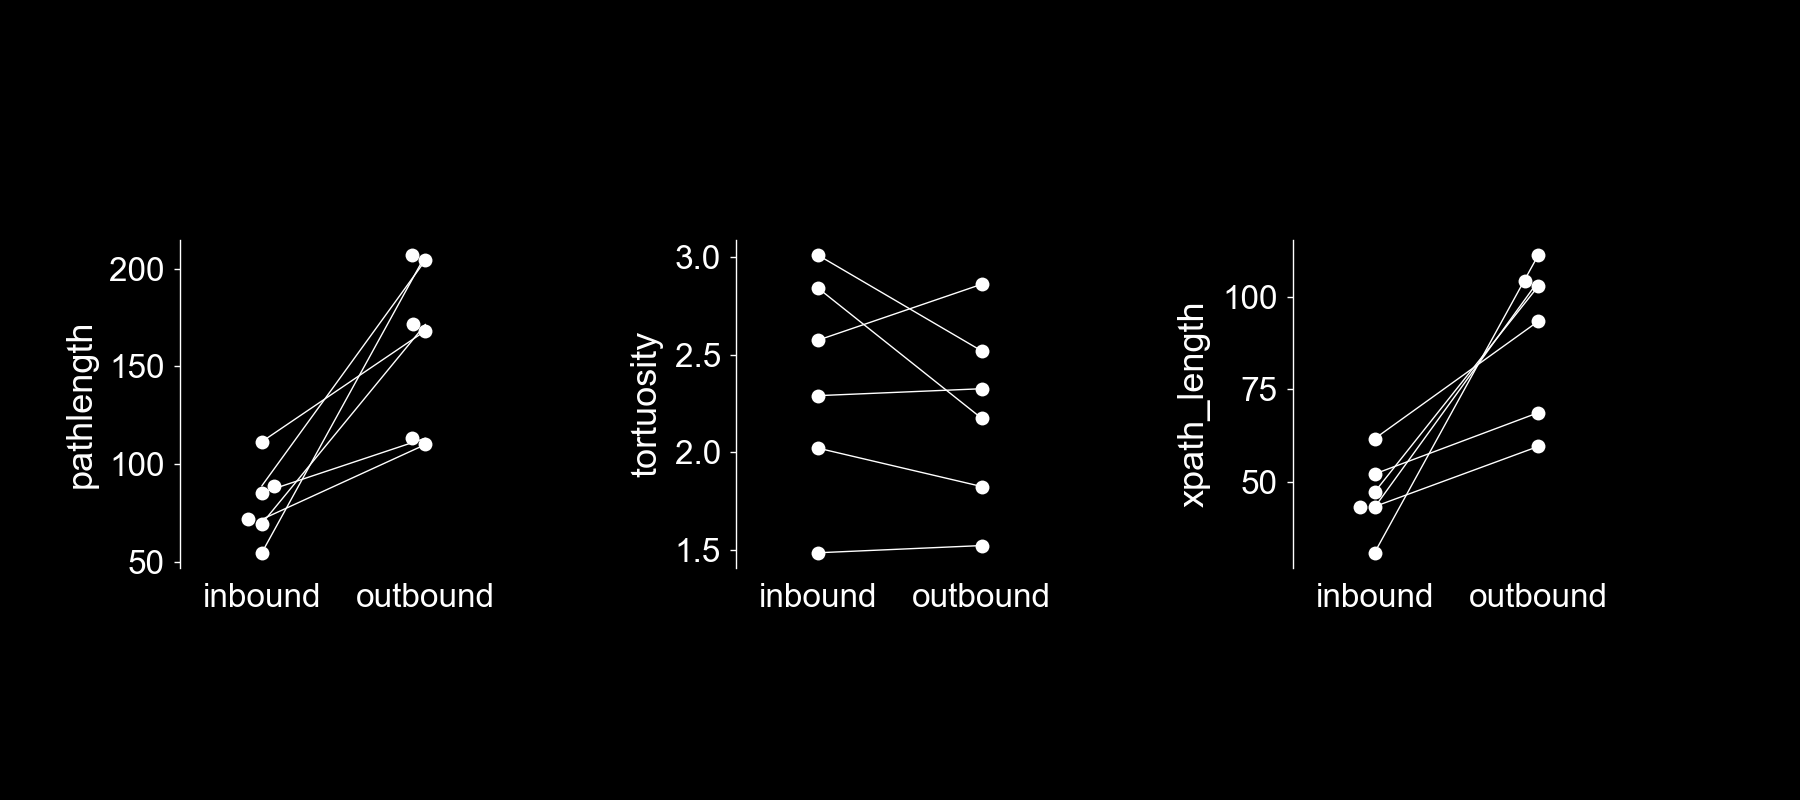

In [144]:
fig, axn = pl.subplots(1, 3, figsize=(9,4))

varnames = ['pathlength', 'tortuosity', 'xpath_length']
for ax, varname in zip(axn.flat, varnames):
    sns.swarmplot(data=meandf, y=varname, x='boutdir', ax=ax, c='w')
    for f, fd in meandf.groupby('filename'):
        ax.plot([0, 1],
                [fd[fd['boutdir']=='inbound'][varname], fd[fd['boutdir']=='outbound'][varname]],
                'w', lw=0.5)
    ax.set_box_aspect(1)
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
                   direction='out', left=True)
    for pos in ['right', 'top', 'bottom']:
       ax.spines[pos].set_visible(False)
    ax.set_xlabel('')
    ax.set_xlim([-0.5, 1.5])
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.7)

pl.savefig(os.path.join(figdir, 'all-flies-summary-tortuosity.png'))

<IPython.core.display.Javascript object>


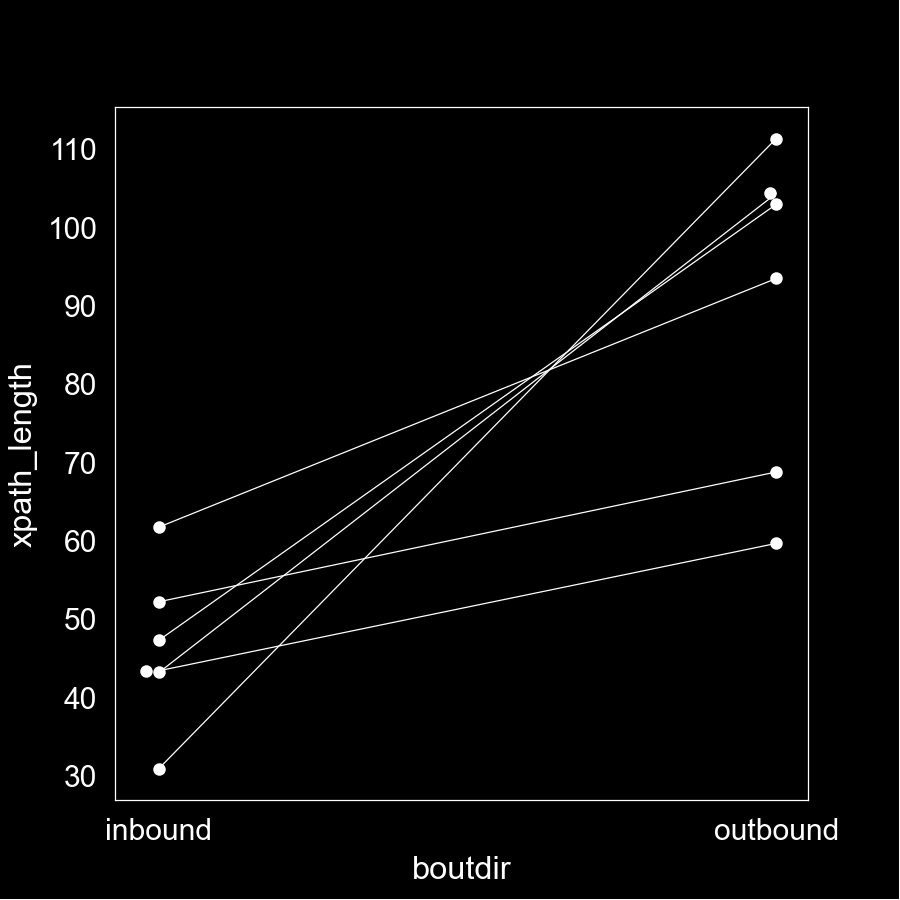

In [108]:
varname = 'xpath_length'
fig, ax = pl.subplots(figsize=(5,5))
#sns.pointplot(data=meandf, y='xpath_length', x='boutdir', ax=ax, markers='_')
sns.swarmplot(data=meandf, y=varname, x='boutdir', ax=ax, c='w')

for f, fd in meandf.groupby('filename'):
    ax.plot([0, 1],
            [fd[fd['boutdir']=='inbound'][varname], fd[fd['boutdir']=='outbound'][varname]],
            'w', lw=0.5)
ax.set_box_aspect(1)

In [95]:
fd

,filename,boutdir,boutnum,pathlength,tortuosity,xpath_length,efficiency,maxdist_x,max_xpos,max_ix
10,20230126-175229_strip_grid_fly1_001.log,inbound,35.32,71.628604,2.291359,43.307983,1.646904,22.597829,114.58361,1391.12
11,20230126-175229_strip_grid_fly1_001.log,outbound,35.32,109.985506,2.326835,59.568674,2.325579,22.597829,114.58361,1391.12


In [51]:
boutdir_palette = {'outbound': 'cyan', 'inbound': 'violet'} #'cyan'}

<IPython.core.display.Javascript object>


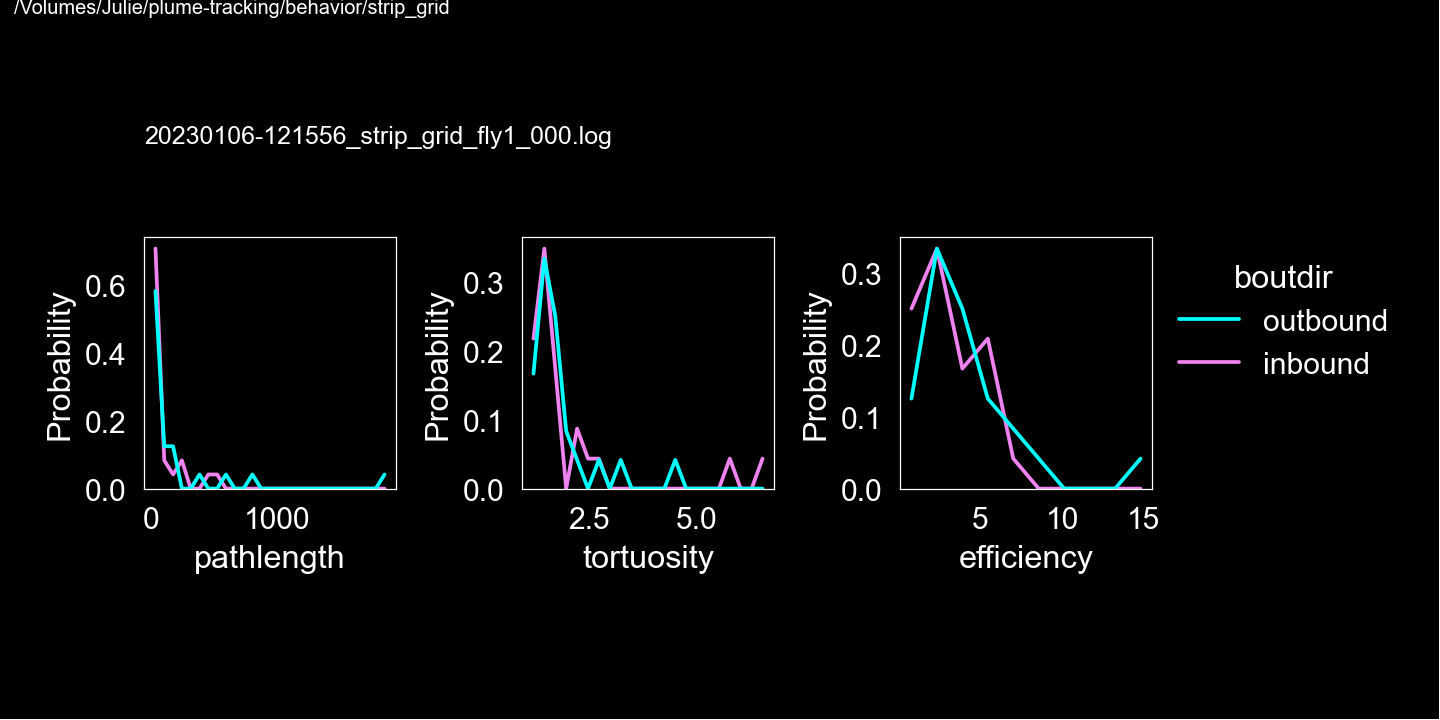

In [60]:


fig = plot_tortuosity_metrics(tortdf, cdf=False, boutdir_palette=boutdir_palette)
util.label_figure(fig, "{}".format(fig_id))
fig.text(0.1, 0.8, fn)
pl.subplots_adjust(right=0.8)
# figname = 'tortuosity-metrics-hist_{}'.format(os.path.splitext(fn)[0])
# print(figname)
# pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)